# Circuit Cutting with Automatic Cut Finding

Circuit cutting is a technique to decompose a quantum circuit into smaller circuits, whose results can be knitted together to reconstruct the original circuit output. 

The circuit knitting toolbox implements a wire cutting method presented in [CutQC](https://doi.org/10.1145/3445814.3446758) (Tang et al.). This method allows a circuit wire to be cut such that the generated subcircuits are amended by measurements in the Pauli bases and by state preparation of four Pauli eigenstates (see Fig. 4 of [CutQC](https://doi.org/10.1145/3445814.3446758)).

This wire cutting technique is comprised of the following basic steps:

1. **Decompose**: Cut a circuit into multiple subcircuits. Here, we'll use an automatic method to find optimal cut(s). See [tutorial 2](tutorial_2_circuit_cutting_manual_cutting.ipynb) to manually cut a circuit.
2. **Evaluate**: Execute those subcircuit on quantum backend.
3. **Reconstruct**: Knit the subcircuit results together to reconstruct the original circuit output (in this case, the full probability distribution).

## Create a quantum circuit with Qiskit

In this case, we'll create a hardware-efficient circuit with two (linear) entangling layers.

In [ ]:
import numpy as np
from qiskit.circuit.library import EfficientSU2

num_qubits = 8
circuit = EfficientSU2(
    num_qubits=num_qubits,
    reps=2,
    entanglement="linear",
    su2_gates=["ry"],
)

circuit = circuit.decompose()

params = [(np.pi * i) / 16 for i in range(len(circuit.parameters))]
circuit = circuit.bind_parameters(params)
circuit.draw('mpl', fold=-1, scale=0.5)

## Set up the Qiskit Runtime Service

The Qiskit Runtime Service provides access to IBM Runtime Primitives and quantum backends.
Alternatively, a local statevector simulator can be used with the Qiskit primitives.

In [2]:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Options,
)
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="<YOUR_API_TOKEN>",
)

The wire cutter tool uses a `Sampler` primitive to evaluate the probabilities of each subcircuit. Here, we configure the options for the Runtime Sampler and specify the backend(s) to be used to evaluate the subcircuits:

In [3]:
# Set the Sampler and runtime options
options = Options(execution={"shots": 8192})

# Run 2 parallel qasm simulator threads
backend_names = ["ibmq_qasm_simulator"] * 2

## Set up the Wire Cutter from the Circuit Knitting Toolbox

Instantiate a `WireCutter` with the circuit and runtime information.

In [4]:
from circuit_knitting_toolbox.circuit_cutting import WireCutter

cutter = WireCutter(
    circuit, service=service, backend_names=backend_names, options=options
)

Note: if only a circuit is passed to `WireCutter`, a local Qiskit Sampler with the statevector simulator will be used instead:<br>
```cutter = WireCutter(circuit)```

## Decompose the circuit with wire cutting

In this example, we will use an automatic method to find cuts matching our criteria. See [tutorial 2](tutorial_2_circuit_cutting_manual_cutting.ipynb) for how to manually cut a circuit.
   * `method='automatic`: Use a mixed integer programming (MIP) model to find optimal cut(s)
   * `max_subcircuit_width (int)`: Only allow subcircuits with 6 qubits or less
   * `max_cuts (int)`: Cut the circuit no more than two times
   * `num_subcircuits (list)`: The number of subcircuits to try, in this case only 2 subcircuits

In [5]:
cuts = cutter.decompose(
    method="automatic",
    max_subcircuit_width=5,
    max_cuts=2,
    num_subcircuits=[2],
)

2022-10-21 16:21:40,772	INFO worker.py:1518 -- Started a local Ray instance.


(cut_circuit_wires pid=2203) Exporting as a LP file to let you check the model that will be solved :  inf <class 'float'>
(cut_circuit_wires pid=2203) Version identifier: 22.1.0.0 | 2022-03-27 | 54982fbec
(cut_circuit_wires pid=2203) CPXPARAM_Read_DataCheck                          1
(cut_circuit_wires pid=2203) CPXPARAM_TimeLimit                               300
(cut_circuit_wires pid=2203) Warning:  Non-integral bounds for integer variables rounded.
(cut_circuit_wires pid=2203) Tried aggregator 3 times.
(cut_circuit_wires pid=2203) MIP Presolve eliminated 37 rows and 8 columns.
(cut_circuit_wires pid=2203) MIP Presolve modified 7 coefficients.
(cut_circuit_wires pid=2203) Aggregator did 103 substitutions.
(cut_circuit_wires pid=2203) Reduced MIP has 366 rows, 127 columns, and 1072 nonzeros.
(cut_circuit_wires pid=2203) Reduced MIP has 121 binaries, 6 generals, 0 SOSs, and 0 indicators.
(cut_circuit_wires pid=2203) Presolve time = 0.00 sec. (2.10 ticks)
(cut_circuit_wires pid=2203) F

**The results from decompose includes information about the wire cutting process, e.g.,**

- `subcircuits`: list of QuantumCircuit objects for the subcircuits
- `complete_path_map`: a dictionary mapping indices of qubits in original circuit to their indices in the subcircuits
- `num_cuts`: the number of times the circuit was cut
- `classical_cost`: the final value of the cost function used to find optimal cut(s)

In [6]:
print(cuts.keys())

dict_keys(['max_subcircuit_width', 'subcircuits', 'complete_path_map', 'num_cuts', 'counter', 'classical_cost'])


**The two subcircuits produced:**

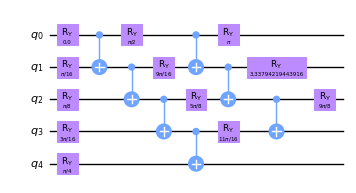

In [7]:
# visualize the first subcircuit
cuts['subcircuits'][0].draw('mpl', fold=-1, scale=0.5)

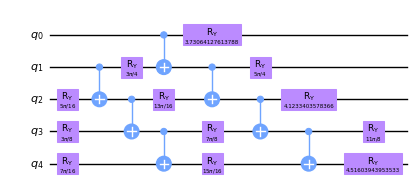

In [8]:
# visualize the second subcircuit
cuts['subcircuits'][1].draw('mpl', fold=-1, scale=0.5)

## Evaluate the subcircuits with Qiskit Runtime


Note that two local cores will be used to support each of the parallel backend threads we specified earlier.

In [9]:
subcircuit_instance_probabilities = cutter.evaluate(cuts)

**Inspecting the subcircuit results**

In this case, the original circuit was cut 2 times (we can also get this info from `cuts['num_cuts']`):

In [10]:
print('Number of subcircuits: ', len(subcircuit_instance_probabilities))

Number of subcircuits:  2


From these two wire cuts, there are $4^2=16$ variants of the first subcircuit corresponding to the combination of measurement bases: $P_i\otimes P_j$, for the Paulis $P_i \in \{I, X, Y, Z \}$. And there are $4^2=16$ variants of the second subcircuit corresponding to the combination of initialization states: $|s_i\rangle\otimes|s_j\rangle$, where $|s_i\rangle \in \{ |0\rangle, |1\rangle, |+\rangle |+i\rangle\}$. 


Note that some subcircuit probabilities can be negative (and not sum to unity). This is because the raw probabilities from subcircuits must be modified to account for the measurement bases of ancillary qubits. See Section 3 of [CutQC](https://doi.org/10.1145/3445814.3446758) for more details.

In [11]:
print('Number of variants of 1st subcircuit: ', len(subcircuit_instance_probabilities[0]))
print('Number of variants of 2nd subcircuit: ', len(subcircuit_instance_probabilities[1]))

Number of variants of 1st subcircuit:  16
Number of variants of 2nd subcircuit:  16


The first subcircuit has two ancillary qubits (induced by the two wire cuts) that do not appear in the original circuit. This means that the first subcircuit has $5-2=3$ qubits from the original circuit and a probability distribution of size $2^3=8$. The second subcircuit has 5 qubits, all from the original circuit, and so its probability distribution is size $2^5=32$.

In [12]:
print('Size of 1st subcircuit probability distribution: ', len(subcircuit_instance_probabilities[0][0]))
print('Size of 2nd subcircuit probability distribution: ', len(subcircuit_instance_probabilities[1][0]))

Size of 1st subcircuit probability distribution:  8
Size of 2nd subcircuit probability distribution:  32


## Reconstruct the full circuit output

Next, the results of the subcircuit experiments are classical postprocessed to reconstruct an estimate of the original circuit's full probability distribution.

In [13]:
%%capture

reconstructed_probabilities = cutter.reconstruct(
    subcircuit_instance_probabilities, cuts
)

Here are the reconstructed probabilities for the original 8-qubit circuit:

In [14]:
print('Size of reconstructed probability distribution: ', len(reconstructed_probabilities))

Size of reconstructed probability distribution:  256


## Verify the results

If the original circuit is small enough, we can use a statevector simulator to check the results of cutting against the original circuit's exact probability distribution (ground truth).

In [15]:
metrics, exact_probabilities = cutter.verify(reconstructed_probabilities)

The verify step includes several metrics, including the chi square loss. More info about each metric can be found in the [utils metrics file](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/circuit_knitting_toolbox/utils/metrics.py).

In [16]:
metrics

{'nearest': {'chi2': 0.009880733766218005,
  'Mean Squared Error': 2.437506505334499e-07,
  'Mean Absolute Percentage Error': 1411.657586761267,
  'Cross Entropy': 3.6914963683488704,
  'HOP': 0.9966810699552298},
 'naive': {'chi2': 0.009149488722012485,
  'Mean Squared Error': 2.381343249240529e-07,
  'Mean Absolute Percentage Error': 3693.630004327715,
  'Cross Entropy': 3.665985412161219,
  'HOP': 0.9939817621707712}}

If we calculated the ground truth above, we can visualize a comparison to the reconstructed probabilities

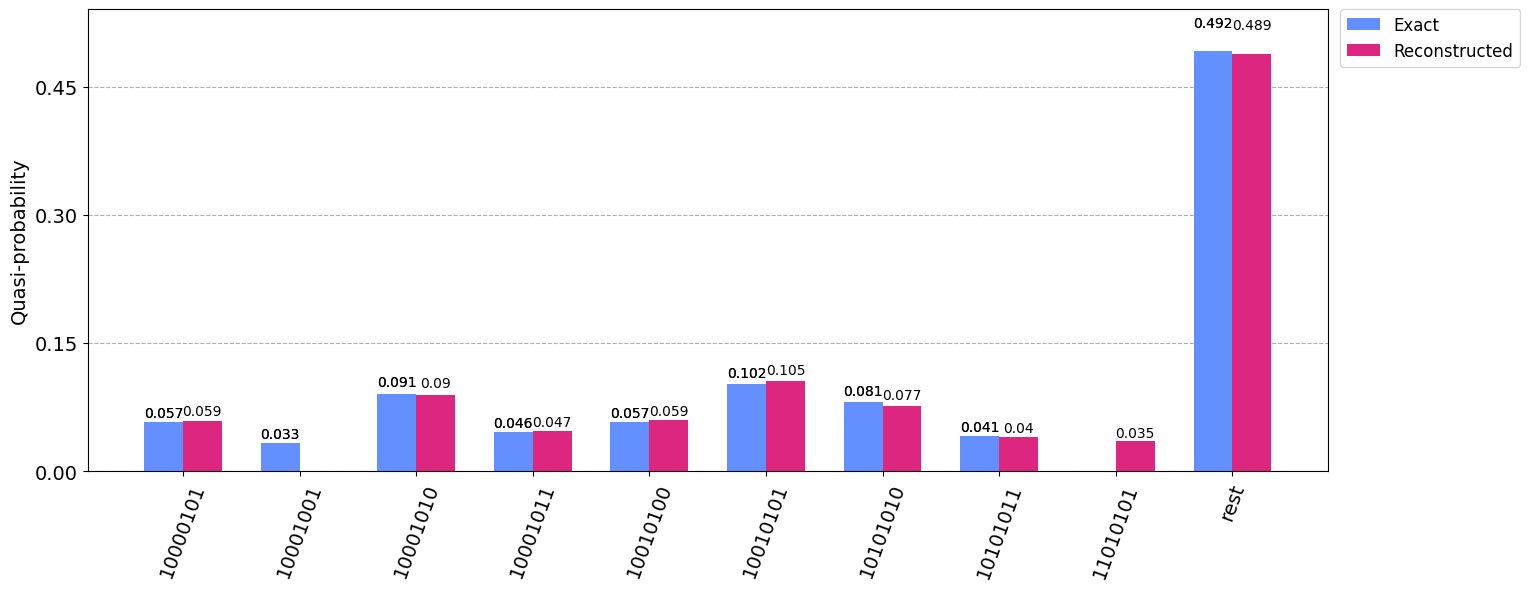

In [17]:
from qiskit.visualization import plot_histogram
from qiskit.result import ProbDistribution

# Create a dict for the reconstructed distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Represent states as bitstrings (instead of ints)
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)


# Create the ground truth distribution dict
exact_distribution = {
    i: prob for i, prob in enumerate(exact_probabilities)
}

# Represent states as bitstrings (instead of ints)
exact_dict_bitstring = ProbDistribution(
    data=exact_distribution
).binary_probabilities(num_bits=num_qubits)

# plot a histogram of the distributions
plot_histogram(
    [exact_dict_bitstring, reconstructed_dict_bitstring],
    number_to_keep=8,
    figsize=(16, 6),
    sort="asc",
    legend=["Exact", "Reconstructed"],
)

In [18]:
import qiskit.tools.jupyter  # pylint: disable=unused-import,wrong-import-order
%qiskit_version_table

This code is a Qiskit project.
© Copyright IBM 2022.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.